# SQL TEST

## 1.

In [79]:
# select count(*) as completed trips per device, request_at at TIME ZONE 'PST'
# from trips
# where request_at between '12/1/2013 10:00:00 PST' AND '12/8/2013 17:00:00 PST'
# and status = 'completed'
# and city_id = 5
# group by device

## 2.

In [80]:
# select count(distinct trips*), request_at at TIME ZONE 'PST'
# from trips
# join(select userid
#   from users
#   where banned = False
#   and role = 'client') as unbanned_clients
# on unbanned_clients.userid = trips.client_id
# where trips.status = 'completed'
# and city_id = 8
# and request_at between '10/1/2013 00:00:00 PST' AND '10/31/2013 00:00:00 PST'

# BUSINESS QUESTIONS
# PART A

## Experiment / Metrics Design

Problem: Manually filling out earnings on tax forms
Improvement: One tax form with all information automatically filled out

	1. How to Measure (what metric) improvement/success is actual one?
-Faster turn around with forms

	2. Other metric candidate:
-Less errors on forms/filled out correctly
-Less lost forms/destroyed in need of replacement

	3. Experiment design that I could use to confirm hypothesis that my chosen key measure is different in the treated group.
		a. Classic A/B Testing: to confirm hypothesis that chosen key measure is different in treated group/to evaluate treatment effects
		b. Make sure have randomized groups for Control group and Treatment group
		c. When determining Sample Size: Need to make sure it is large enough to yield high statistical power
		d. Data Pre-Processing: 
			i. ratio between control and treatment groups not significantly different 
			ii. Check Metric: What type? This determines hypothesis testing process type
				1) Continuous
				2) Ratio
				3) Proportional
			iii. Outlier Detection/Variance Reduction/Pre-Experiment Bias (Need to be sensitive to these so that they do not pollute dataset)
		e. P-Value Calculation (Significance)
			i. Sample Size can come in different sizes
				1) Skewed
				2) Small
				3) Large
					a) Based on these, there are different tests that are run
						i) T-test
						ii) Chi-Square Test
		f. Lift (see if there is a significant different in treatment group)
		g. Power Calculation performed in order to see the level of confidence in analysis

Some discussion:
Experimental outcomes that constitute success/failure will be based on setting alpha commonly set at 0.05 as the cutoff for significance. If the p-value is <0.05, we reject the null hypothesis that there is no difference between the means and conclude that a significant difference does exist. 

However, what would negatively impact the validity of the experiment would be "network effect". The success of the new feature could simply be due to other reasons outside of treatment group. Validity of A/B tests rest on treatment only affecting behavior of treated users, which is not always the case. 

In order to remedy this, researcher performing experiment could assign treatments randomly based on clusters of users rather than individual users so that network effect is worked against in experiment. 

# PART B

## Data Analysis

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline
from scipy import stats
import itertools
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [82]:
EATSFin = pd.read_csv("Exercise.csv")

In [83]:
list(EATSFin)

['Date', 'Vendor Name', 'Country', 'Product', ' Gross Bookings ', ' Fees ']

In [84]:
EATSFin.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
0,1/1/15,Vendor A,Country 1,Product 1,63.34,0.94
1,1/1/15,Vendor A,Country 2,Product 2,39295.41,2169.53
2,1/1/15,Vendor A,Country 3,Product 3,127.25,3.44
3,1/1/15,Vendor A,Country 4,Product 1,4.85,0.11
4,1/1/15,Vendor A,Country 5,Product 4,4734.94,171.13


In [85]:
EATSFin.tail()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
7906,4/1/16,Vendor A,Country 32,Product 9,29573.34,504.32
7907,4/1/16,Vendor A,Country 27,Product 2,79.98,6.79
7908,4/1/16,Vendor A,Country 37,Product 4,122769.7,8156.34
7909,4/1/16,Vendor A,Country 28,Product 2,167.76,14.24
7910,4/1/16,Vendor A,Country 70,Product 14,23.35,1.12


Some intitial observations:
1. Dataset spans over 13-month period
2. Various Vendors, Countries and Products
3. Huge ranges between rows

In [86]:
EATSFin.describe()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
count,7911,7911,7907,7911,7911,7911
unique,16,10,78,22,7304,5763
top,4/1/16,Vendor A,Country 2,Product 4,$-,0.02
freq,694,5629,320,1580,238,65


There is obviously something wrong with data format since summary statistics are not being printed out from .describe()

# Data Cleaning

In [87]:
#Checking each column's data type to see what may be cause.
EATSFin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911 entries, 0 to 7910
Data columns (total 6 columns):
Date                7911 non-null object
Vendor Name         7911 non-null object
Country             7907 non-null object
Product             7911 non-null object
 Gross Bookings     7911 non-null object
 Fees               7911 non-null object
dtypes: object(6)
memory usage: 370.9+ KB


Bingo! The column types are non-null objects.

Need to change the columns with numbers from obj-->numeric

Another thing to notice here is that Country column has 4 rows that are not present since the whole data set technically has 7911 rows.

Before changing data types, need to covert null values to: NaN's.

In [88]:
#Locate all null's aka string -'$-' in Gross Bookings

mask = np.column_stack([EATSFin[' Gross Bookings '].str.contains(r"\$", na=False) for col in EATSFin])
EATSFin.loc[mask.any(axis=1)]

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
281,1/1/15,Vendor F,Country 2,Product 6,$-,160.94
283,1/1/15,Vendor D,Country 2,Product 16,$-,9709.01
359,2/1/15,Vendor D,Country 2,Product 16,$-,6589.98
520,2/1/15,Vendor F,Country 2,Product 6,$-,191.28
643,3/1/15,Vendor D,Country 2,Product 16,$-,7655.64
681,3/1/15,Vendor F,Country 2,Product 6,$-,170.9
950,4/1/15,Vendor F,Country 2,Product 6,$-,139.99
1203,4/1/15,Vendor D,Country 2,Product 16,$-,12426.51
1324,5/1/15,Vendor F,Country 2,Product 6,$-,175.19
1369,5/1/15,Vendor D,Country 2,Product 16,$-,31203.5


## 238 total rows. 238/7911 = 0.0300846922, which is approximately 3% of the data. Will eliminate all these rows since they do not represent significant portion of dataset.

In [89]:
#Locate all null's aka string -'$-' in Fees
mask = np.column_stack([EATSFin[' Fees '].str.contains(r"\$", na=False) for col in EATSFin])
EATSFin.loc[mask.any(axis=1)].head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
71,1/1/15,Vendor A,Country 35,Product 12,-2.33,$-
168,1/1/15,Vendor A,Country 19,Product 10,-0.44,$-
192,1/1/15,Vendor D,Country 2,Product 14,585.99,$-
358,2/1/15,Vendor D,Country 2,Product 14,562.81,$-
779,3/1/15,Vendor D,Country 2,Product 14,775.12,$-


In [90]:
mask = np.column_stack([EATSFin[' Fees '].str.contains(r"\$", na=False) for col in EATSFin])
EATSFin.loc[mask.any(axis=1)].count()

Date                51
Vendor Name         51
Country             51
Product             51
 Gross Bookings     51
 Fees               51
dtype: int64

## 51 total rows. 51/7911 = 0.00644671975, which is approximately 0.6% of the data. Can afford to take out all these rows as well.

After dropping rows with '$-', dataframe should be between the size: 7673 and 7622 (assuming there are no character overlaps between 'Gross Bookings' and 'Fees' or character in both columns.

In [91]:
EATSFin[' Gross Bookings '] = pd.to_numeric(EATSFin[' Gross Bookings '], errors='coerce')

In [92]:
#From original data table, entry @ index: 7882, column Gross Bookings was empty and now should be filled with NaN.
EATSFin.iloc[[7882]]

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
7882,4/1/16,Vendor F,Country 2,Product 6,NaN,366.82


Finally- EATSFin[' Gross Bookings '] converted to NaN. Next step is to produce df w/o NaN's.

In [93]:
EATSFin[' Gross Bookings '] = pd.to_numeric(EATSFin[' Gross Bookings '], errors='coerce').dropna()

In [94]:
EATSFin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911 entries, 0 to 7910
Data columns (total 6 columns):
Date                7911 non-null object
Vendor Name         7911 non-null object
Country             7907 non-null object
Product             7911 non-null object
 Gross Bookings     7673 non-null float64
 Fees               7911 non-null object
dtypes: float64(1), object(5)
memory usage: 370.9+ KB


As expected, ' Gross Bookings ' column reduced to 7673, but need to actually reduce the whole dataframe to that number.

Will extract rows that don't have NaN's. This should produce the desired result.

In [95]:
EATSFin2 = EATSFin[pd.notnull(EATSFin[' Gross Bookings '])]

In [96]:
EATSFin2.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
0,1/1/15,Vendor A,Country 1,Product 1,63.34,0.94
1,1/1/15,Vendor A,Country 2,Product 2,39295.41,2169.53
2,1/1/15,Vendor A,Country 3,Product 3,127.25,3.44
3,1/1/15,Vendor A,Country 4,Product 1,4.85,0.11
4,1/1/15,Vendor A,Country 5,Product 4,4734.94,171.13


Woohoo!!! Dataframe is reduced to 7673! Awesome. Now moving onto eliminating '$-' in 'Fees'

In [97]:
EATSFin2[' Fees '] = pd.to_numeric(EATSFin2[' Fees '], errors='coerce')

In [98]:
#Test to see that rows with '$-' in 'Fees' column converted to NaN
#From original data table, entry @ index: 71, column Fees was empty and now should be filled with NaN.
EATSFin2.iloc[[71]]

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
71,1/1/15,Vendor A,Country 35,Product 12,-2.33,NaN


Yes! Now extract all rows from EATSFin that do not have NaN

In [99]:
EATSFin3 = EATSFin2[pd.notnull(EATSFin2[' Fees '])]

In [100]:
EATSFin3.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
0,1/1/15,Vendor A,Country 1,Product 1,63.34,0.94
1,1/1/15,Vendor A,Country 2,Product 2,39295.41,2169.53
2,1/1/15,Vendor A,Country 3,Product 3,127.25,3.44
3,1/1/15,Vendor A,Country 4,Product 1,4.85,0.11
4,1/1/15,Vendor A,Country 5,Product 4,4734.94,171.13


Great! As expected, EATSFin without rows with '$-' would be >= 7622 and <7673 remaining rows. And 7639 is right in between. =)

Now, we want to see if .describe works with transformed datatypes and eliminated NaN's to see distribution of values.

In [101]:
EATSFin3.describe()

,Gross Bookings,Fees
count,7.639000e+03,7.639000e+03
mean,4.445231e+05,1.551625e+04
std,3.109744e+06,1.234557e+05
min,-2.701010e+03,-2.900000e-01
25%,7.562000e+01,3.105000e+00
50%,2.483660e+03,1.050200e+02
75%,3.970618e+04,1.363080e+03
max,6.873661e+07,6.135380e+06


Yes! Now, we can go ahead and eliminate any outliers. In order to better see that data, we can boxplot these columns to visualize those points that are far from the main cluster.

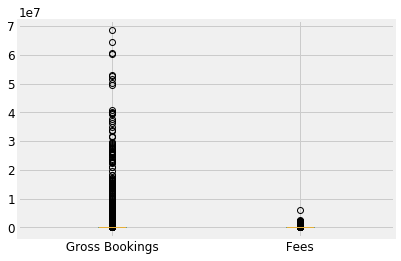

In [102]:
boxplot = EATSFin3.boxplot(column=[' Gross Bookings ', ' Fees '])

Based on this, it looks like there is a greater spread in ' Gross Bookings '. Outliers will be removed since this is  regression problem. Accurate regressions need to have outliers eliminated.

We will use zcore to drop outliers. Zscore: In this procedure, z-score is calculated for each observation. Any z-score greater than 3 or less than -3 is considered to be an outlier. This rule of thumb is based on the empirical rule. From this rule we see that almost all of the data (99.7%) should be within three standard deviations from the mean.

In [103]:
EATSFin4 = EATSFin3[(np.abs(stats.zscore(EATSFin3.drop(['Date', 'Vendor Name', 'Country', 'Product'], 
                                                       axis=1))) < 3).all(axis=1)]

To check that outliers removed:
1. new summary statistics should have max value < max value from previous df that still had outliers. 
2. new boxplot should not have points scattered in remote areas from mean and SD's

In [104]:
EATSFin4.describe()

,Gross Bookings,Fees
count,7.551000e+03,7551.000000
mean,1.614825e+05,6363.368809
std,7.249687e+05,25696.424125
min,-2.701010e+03,-0.290000
25%,7.196000e+01,2.960000
50%,2.284680e+03,97.100000
75%,3.630036e+04,1239.860000
max,8.956605e+06,357333.080000


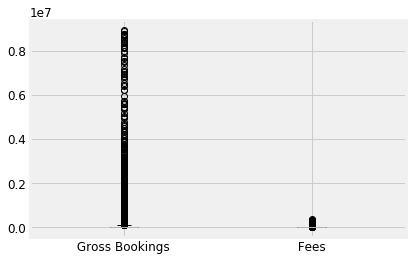

In [105]:
boxplot = EATSFin4.boxplot(column=[' Gross Bookings ', ' Fees '])

Yes, outliers removed! Spread is more compact for Gross Bookings and Fees.

In [106]:
EATSFin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7910
Data columns (total 6 columns):
Date                7551 non-null object
Vendor Name         7551 non-null object
Country             7547 non-null object
Product             7551 non-null object
 Gross Bookings     7551 non-null float64
 Fees               7551 non-null float64
dtypes: float64(2), object(4)
memory usage: 412.9+ KB


Now, we are going to convert the 'Date' column from non-null object to Python's date time format.

In [107]:
from datetime import datetime
EATSFin4['Date'] =  pd.to_datetime(EATSFin4['Date'],
                              format='%m/%d/%y')

Confirming 'Date' column changed from non-null object to datetime.

In [108]:
EATSFin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7910
Data columns (total 6 columns):
Date                7551 non-null datetime64[ns]
Vendor Name         7551 non-null object
Country             7547 non-null object
Product             7551 non-null object
 Gross Bookings     7551 non-null float64
 Fees               7551 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 412.9+ KB


Yes! Confirmed datetime.

Also confirming float types in order to properly calculate new percentage column.
At this point, need to add new column, "% Gross Bookings" to edited dataframe.

In [109]:
#Need to get total amount from ' Gross Bookings ' to use in new column calculation
gross_sum = EATSFin4[' Gross Bookings '].sum()

In [110]:
gross_sum

1219353980.27

In [111]:
#Creating '% Gross Bookings' column. 
EATSFin4['% Gross Bookings'] = (EATSFin4[' Gross Bookings '] / gross_sum) *100

In [112]:
EATSFin4.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
0,2015-01-01,Vendor A,Country 1,Product 1,63.34,0.94,5.194554e-06
1,2015-01-01,Vendor A,Country 2,Product 2,39295.41,2169.53,3.222642e-03
2,2015-01-01,Vendor A,Country 3,Product 3,127.25,3.44,1.043585e-05
3,2015-01-01,Vendor A,Country 4,Product 1,4.85,0.11,3.977516e-07
4,2015-01-01,Vendor A,Country 5,Product 4,4734.94,171.13,3.883155e-04


I noticed that 'Date' column just got changed. Instead of being month/day/year(2 digits), it has become year(4 digits)-month-day. Need to verify this with tail end of dataframe.

In [113]:
EATSFin4.tail()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
7906,2016-04-01,Vendor A,Country 32,Product 9,29573.34,504.32,0.002425
7907,2016-04-01,Vendor A,Country 27,Product 2,79.98,6.79,0.000007
7908,2016-04-01,Vendor A,Country 37,Product 4,122769.70,8156.34,0.010068
7909,2016-04-01,Vendor A,Country 28,Product 2,167.76,14.24,0.000014
7910,2016-04-01,Vendor A,Country 70,Product 14,23.35,1.12,0.000002


The 'Date' column has been changed to year(4 digits)-month-day. Keep this in mind as I analyze visualizations.

# Exploratory Data Analysis

After manually inspecting data, suspecting that each month's data may have varying amounts of data. This affects model building as accuracy of model depends on how even data is between dates. Will re-inspect data with date counts to see distribution of data.

In [114]:
EATSFin4_dategroups = EATSFin4.groupby(['Date'])

In [115]:
EATSFin4_dategroups.count()

,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
Date,,,,,,
2015-01-01,297,297,297,297,297,297
2015-02-01,304,304,304,304,304,304
2015-03-01,321,321,321,321,321,321
2015-04-01,325,325,325,325,325,325
2015-05-01,350,350,350,350,350,350
2015-06-01,366,366,366,366,366,366
2015-07-01,359,359,359,359,359,359
2015-08-01,475,474,475,475,475,475
2015-09-01,483,482,483,483,483,483


As suspected, distribution of total datasets points is not the same month-to-month. There is growth in datapoint density per month starting with around 300 at the beginning of dataset doubling to around 600 at the end. At the same time, this is just a count and not a sum of data points.

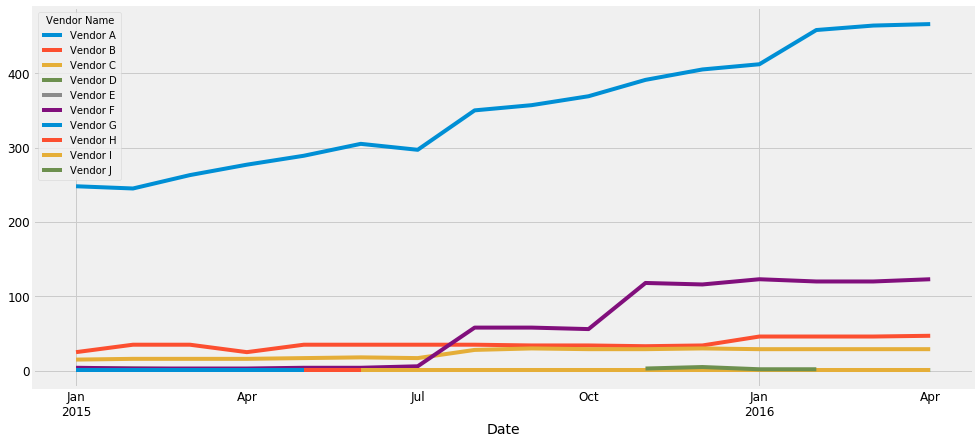

In [116]:
#Vendor Name Groups' % Gross Bookings vs. Time
fig, ax = plt.subplots(figsize=(15,7))

EATSFin4.groupby(['Date','Vendor Name']).count()['% Gross Bookings'].unstack().plot(ax=ax)

In [117]:
EATSFin4.groupby('Vendor Name')['% Gross Bookings'].sum()

Vendor Name
Vendor A    50.916361
Vendor B     7.109077
Vendor C    12.691010
Vendor D     5.243848
Vendor E     1.012620
Vendor F    15.690606
Vendor G     2.071597
Vendor H     0.343401
Vendor I     2.403793
Vendor J     2.517688
Name: % Gross Bookings, dtype: float64

Vendor A is way above every other Vendor. And Vendor F is the next highly ranked though there is a huge separation between the two. These two vendors would be worth investing in.

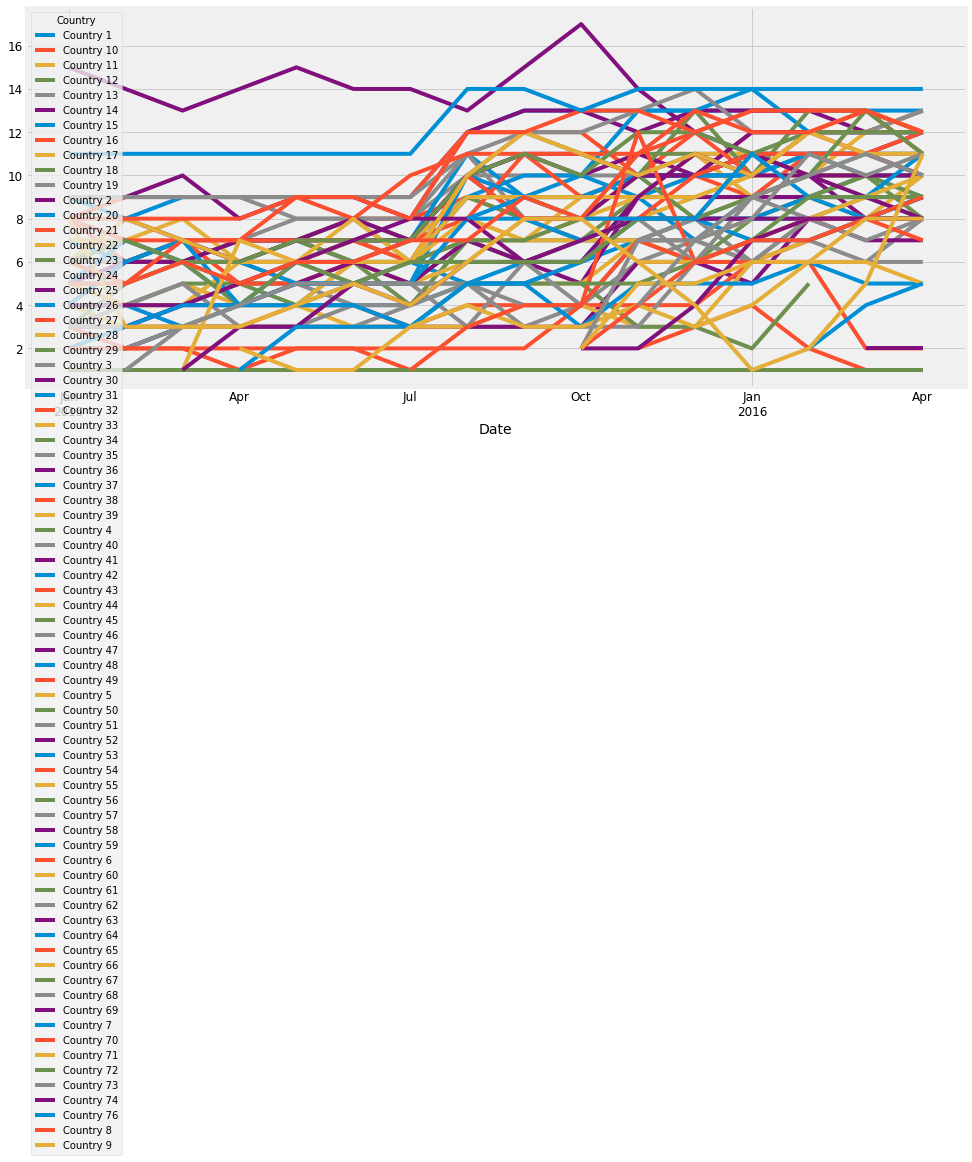

In [118]:
#Country Groups' % Gross Bookings vs. Time
fig, ax = plt.subplots(figsize=(15,7))


EATSFin4.groupby(['Date','Country']).count()['% Gross Bookings'].unstack().plot(ax=ax)

In [119]:
EATSFin4.groupby('Country')['% Gross Bookings'].sum()

Country
Country 1     3.649909e-01
Country 10    1.028741e+00
Country 11    2.375617e-01
Country 12    3.662697e-01
Country 13    5.841654e-01
Country 14    2.905689e-01
Country 15    1.907751e-01
Country 16    3.835875e-02
Country 17    1.496029e-01
Country 18    7.174580e+00
Country 19    2.525640e+00
Country 2     2.833102e+01
Country 20    3.596637e-01
Country 21    1.074426e-01
Country 22    4.538509e-02
Country 23    1.488362e+00
Country 24    2.340222e-01
Country 25    6.441198e-01
Country 26    1.428761e-01
Country 27    1.717546e-01
Country 28    2.681465e-01
Country 29    1.925865e+00
Country 3     7.947263e+00
Country 30    1.113551e+00
Country 31    1.712618e+00
Country 32    8.844420e-02
Country 33    7.742727e-02
Country 34    6.400878e-01
Country 35    1.086950e+01
Country 36    5.810803e-01
                  ...     
Country 50    7.906024e-01
Country 51    8.498345e-02
Country 52    8.402483e-01
Country 53    1.228766e+00
Country 54    4.976728e+00
Country 55    1.9271

There are differences in how much each country contribute to '% Gross Bookings'. Most countries are above 2 units for '% Gross Bookings'. Countries 2 and 7 have separated themselves from the rest of the pack.

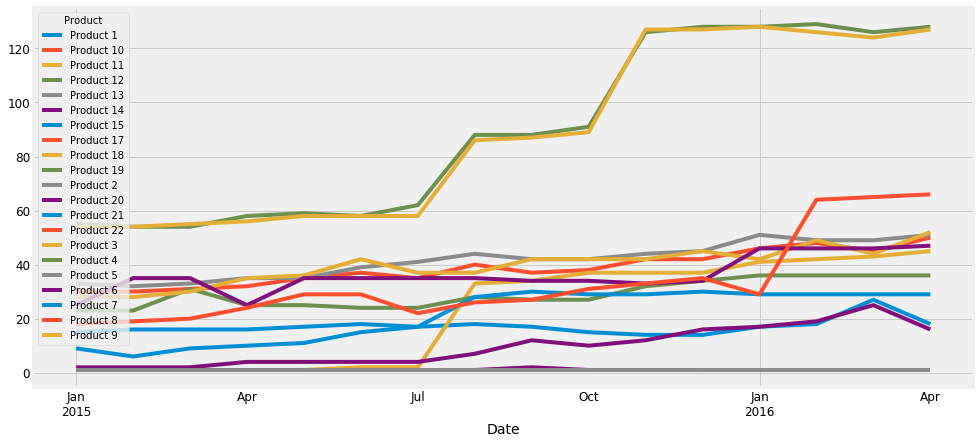

In [120]:
#Product Groups' % Gross Bookings vs. Time
fig, ax = plt.subplots(figsize=(15,7))


EATSFin4.groupby(['Date','Product']).count()['% Gross Bookings'].unstack().plot(ax=ax)

In [121]:
EATSFin4.groupby('Product')['% Gross Bookings'].sum()

Product
Product 1      0.007059
Product 10     0.045841
Product 11     2.073982
Product 12     2.249093
Product 13     1.012620
Product 14     0.062385
Product 15     0.000035
Product 17     2.071597
Product 18     0.343401
Product 19     2.403793
Product 2      3.022834
Product 20     0.000015
Product 21     1.617317
Product 22     1.066079
Product 3      0.013091
Product 4     26.366356
Product 5      4.693262
Product 6      7.109077
Product 7     12.691010
Product 8      0.188323
Product 9     32.962831
Name: % Gross Bookings, dtype: float64

There are two products- 4 and 9 that are doing 3x better than the rest. Maybe a good idea to drop any products below 20 units. Looking at Fees that are tied to these products could strengthen argument to drop these low performing products.

One last data grouping I wanted to examine was how each product was distributed across vendors.

In [122]:
gb = EATSFin4.groupby('Vendor Name')    
[gb.get_group(x) for x in gb.groups]

[           Date Vendor Name     Country     Product   Gross Bookings   \
 0    2015-01-01    Vendor A   Country 1   Product 1             63.34   
 1    2015-01-01    Vendor A   Country 2   Product 2          39295.41   
 2    2015-01-01    Vendor A   Country 3   Product 3            127.25   
 3    2015-01-01    Vendor A   Country 4   Product 1              4.85   
 4    2015-01-01    Vendor A   Country 5   Product 4           4734.94   
 5    2015-01-01    Vendor A   Country 6   Product 2             60.74   
 6    2015-01-01    Vendor A   Country 7   Product 5            -90.74   
 7    2015-01-01    Vendor A   Country 8   Product 2           1460.80   
 13   2015-01-01    Vendor A   Country 5   Product 3             19.34   
 14   2015-01-01    Vendor A   Country 7   Product 8            437.01   
 15   2015-01-01    Vendor A   Country 9   Product 9           4723.55   
 16   2015-01-01    Vendor A  Country 11   Product 4          26643.05   
 17   2015-01-01    Vendor A  Country 

After examining which products were tied to each vendor, most of the time a vendor was tied to one product. Other times, there was a vendor who had multiple products over the span of 16 months (e.g Vendors A and F). Some vendors with multiple products had clear out-performers. And with Vendor F, there seemed to be a shift in sales strategy since there was a shift in focusing on Products 4 and 9 only during the month of April of 2016. Lastly, due to the success of Products 4 and 9, it seemed like Vendor J was brought on board in order to increase sales with those two Products.

Looking at the visualization that broke down 16 month '% Gross Bookings' trend for each Product, there can be inference of which Products within a Vendors' data performed best (2 that outperformed the rest - Products 4 and 9). Though this was based on the assumption that all Vendors offered all the Products, which was not the case. After breaking down the dataset by Vendors, I was able to see the distribution of Products. And most of the time, a Vendor was dedicated to one Product. Only Vendors A, D and F had a variety of Products. Therefore, we were able to pinpoint which Products were high-performing as well as which Vendors were selling those Products in order to quantify the financial impact of all Products.

Now, moving on to building the predictive model. 

## Categorizing the Problem:
Have labels --> Supervised Learning
## Categorizing by Output:
Output is a # --> Regression

### Model that will be used is:
Linear Regression since computing a continuous value.
Goal is to predict future value of process that has been run.

## Visualizing % Gross Bookings Time Series data

In [123]:
EATSFin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7910
Data columns (total 7 columns):
Date                7551 non-null datetime64[ns]
Vendor Name         7551 non-null object
Country             7547 non-null object
Product             7551 non-null object
 Gross Bookings     7551 non-null float64
 Fees               7551 non-null float64
% Gross Bookings    7551 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 471.9+ KB


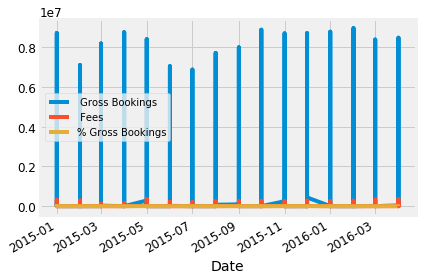

In [124]:
EATSFin4.set_index('Date').plot()

Some things to notice are that within 2015, there are dips in Gross Bookings in Feb, June, July and August. And for 2016, relative to 2015, 2016 has higher Gross Bookings at the beginning of its year.

Fees look even across the graph though this graph is not very granular. The same goes for % Gross Bookings. The values in this column as well as Fees column are very small compared to the values in Gross Bookings column.

There does not seem to be seasonality nor cyclical behavior nor any spikes nor any upper nor lower trends across this data that spans over 1.3 years.

## '% Gross Bookings' - univariate without trend nor seasonal components.

In [125]:
#Attempted to use Autoregression model, but result was poor so explored other models.

In [126]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# dataset
data = EATSFin4['% Gross Bookings'].values
# fit model
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[-0.0001137]


In [127]:
(EATSFin4['% Gross Bookings'] < 0).sum()

50

In [128]:
#There are 50 total negative values out of 7551 values. It does not make sense that the prediction is a negative value...
#Trying another regression (linear regression)

In [129]:
#Tested out building Linear Regression model. Now time to build real model.

#1. Divide dataset into Training and Test sets
#2. Build model using Training set (all data up to 2016-03-01)
#3. Using model, make prediction using Test set date values (2016-04-01)
#4. Validate model by comparing actual Test set y-values to predicted Test set y-values using RMSE values.

In [130]:
#Formatting 'Date' column so that linear regression model can be built.
import datetime as dt

date_col = pd.to_datetime(EATSFin4['Date'])
date_col = date_col.map(dt.datetime.toordinal)

date_col = date_col.values.reshape(-1,1)

In [131]:
#Training Set: Every month except for 2016-04-01.
Tr_x = date_col[:6882]
Tr_y = EATSFin4['% Gross Bookings'][:6882]

In [132]:
#Test Set: Only 2016-04-01 dates.
Te_x = date_col[6882:]
Te_y = EATSFin4['% Gross Bookings'][6882:]

In [133]:
#Build model using Training Set
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

lm = LinearRegression().fit(Tr_x, Tr_y)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [134]:
#Using model, make prediction using Test set date values (2016-04-01)
lm_Te_predictions =  lm.predict(Te_x)
lm_Te_predictions

array([0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382625,
       0.01382625, 0.01382625, 0.01382625, 0.01382625, 0.01382

In [135]:
#Validate model by comparing actual Test set y-values to predicted Test set y-values using RMSE values.
from sklearn.metrics import mean_squared_error
import numpy as np

lin_mse = mean_squared_error(Te_y, lm_Te_predictions)
Te_lin_rmse = np.sqrt(lin_mse)
Te_lin_rmse

0.05634574441239846

A well-fitting regression model results in predicted values close to the observed data values.
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values.
Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction, which is the case here.

The RMSE value for our model is .06 away from 0, which means that the model predicted the response really well as the result was very close to actual response values from Training set.

In [136]:
# Predictions for May 2016 Based on Model Output

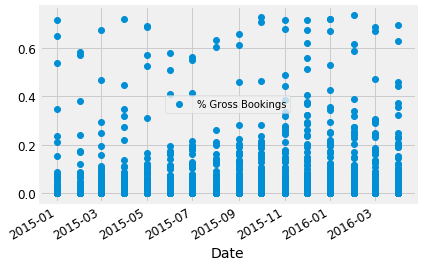

In [137]:
#True data and Predicted data

#TRUE:
EATSFin4.plot(x='Date'[:6882], y='% Gross Bookings'[:6882], style='o')

In [138]:
#PREDICTED:
#So predicted was based on assumption that May 2016 pattern would parallel April 2016 closely since Jan-April 2016 data was 
#very similar based on amount of data points and % Gross Bookings values.
#Build new dataframe first with 2016-05-01 entries. % Gross bookings for that time period added as new predicted values column.

May_2016 = pd.read_csv("May_2016.csv")

In [139]:
May_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 2 columns):
Date                669 non-null object
% Gross Bookings    0 non-null float64
dtypes: float64(1), object(1)
memory usage: 10.5+ KB


In [140]:
May_2016['Date'] =  pd.to_datetime(May_2016['Date'],
                              format='%m/%d/%Y')

In [141]:
#Check 'Date' column format
May_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 2 columns):
Date                669 non-null datetime64[ns]
% Gross Bookings    0 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.5 KB


In [142]:
len(lm_Te_predictions)

669

In [143]:
#Confirmed that column and array have same amount of entries. Proceeded with creating a matrix of May 1, 2016 dates 
#and corresponding predictions from model. This was then used to visualize predictions for that time period.
May_2016['% Gross Bookings'] = lm_Te_predictions

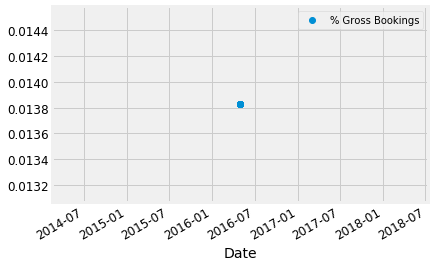

In [144]:
May_2016.plot(x='Date', y='% Gross Bookings', style='o')

I chose a simple Linear Regression model because of the % Gross Bookings trend being uniform, non-seasonal, non-cyclical.

Even though this is the case, I still want to try using Facebook's Prophet in order to try and 
build prediction for May 2016 since these applications detect outliers and bends in graph better.

## Forecasting with FB's Prophet

In [145]:
from fbprophet import Prophet

In [146]:
EATSFin4.tail() #Making sure date is Prophet friendly. And it is!

,Date,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
7906,2016-04-01,Vendor A,Country 32,Product 9,29573.34,504.32,0.002425
7907,2016-04-01,Vendor A,Country 27,Product 2,79.98,6.79,0.000007
7908,2016-04-01,Vendor A,Country 37,Product 4,122769.70,8156.34,0.010068
7909,2016-04-01,Vendor A,Country 28,Product 2,167.76,14.24,0.000014
7910,2016-04-01,Vendor A,Country 70,Product 14,23.35,1.12,0.000002


Now before actually forecasting, will break down data into Vendor groups for prediction.
For each Time Series, there will be 'Date' as x-axis and '% Gross Bookings' as y-axis

In [147]:
def get_prediction(df):
    prediction = {}
    df = df.rename(columns={'Date': 'ds','% Gross Bookings': 'y', 'Vendor Name': 'vendor'})
    list_vendors = df.vendor.unique()

    for vendor in list_vendors:
        vendor_df = df.loc[df['vendor'] == vendor]
        # the Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
        my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0)
        my_model.fit(vendor_df)
        future_dates = my_model.make_future_dataframe(periods=6, freq='MS')
        forecast = my_model.predict(future_dates)
        prediction[vendor] = forecast
    return prediction

In [148]:
forecast_data2 = get_prediction(EATSFin4)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 17.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.for

In [149]:
forecast_data2.keys()

dict_keys(['Vendor A', 'Vendor B', 'Vendor C', 'Vendor D', 'Vendor E', 'Vendor F', 'Vendor G', 'Vendor H', 'Vendor I', 'Vendor J'])

In [150]:
forecast_data2.values()

dict_values([             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2015-01-01  0.001395   -0.047781    0.057536     0.001395     0.001395   
1    2015-01-01  0.001395   -0.045446    0.054549     0.001395     0.001395   
2    2015-01-01  0.001395   -0.042256    0.057659     0.001395     0.001395   
3    2015-01-01  0.001395   -0.050581    0.057282     0.001395     0.001395   
4    2015-01-01  0.001395   -0.042962    0.059874     0.001395     0.001395   
5    2015-01-01  0.001395   -0.046625    0.056105     0.001395     0.001395   
6    2015-01-01  0.001395   -0.046069    0.058563     0.001395     0.001395   
7    2015-01-01  0.001395   -0.046401    0.058567     0.001395     0.001395   
8    2015-01-01  0.001395   -0.047220    0.061207     0.001395     0.001395   
9    2015-01-01  0.001395   -0.045608    0.056409     0.001395     0.001395   
10   2015-01-01  0.001395   -0.042009    0.057055     0.001395     0.001395   
11   2015-01-01  0.001395   -0.048457  

Forecasted data is stored in a dictionary comprised of 10 different Vendor keys: A, B, C, D, E, F, G, H, I and J each paired with 1 of 10 different Dataframe values. Each dataframe is comprised of varying amount of rows, but all dataframes have 19 columns. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [151]:
def vendor_prediction_graphs(df):
    prediction = {}
    df = df.rename(columns={'Date': 'ds','% Gross Bookings': 'y', 'Vendor Name': 'vendor'})
    list_vendors = df.vendor.unique()

    for vendor in list_vendors:
        vendor_df = df.loc[df['vendor'] == vendor]
        # the Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
        my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0)
        my_model.fit(vendor_df)
        future_dates = my_model.make_future_dataframe(periods=6, freq='MS')
        forecast = my_model.predict(future_dates)
        prediction[vendor] = forecast #dictionary data type
        fig = my_model.plot(forecast);
        
        #Forecasts' trend components figures
        fig_components = my_model.plot_components(forecast);
    
    return list_vendors
    return fig
    return fig_components

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 17.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.for

array(['Vendor A', 'Vendor B', 'Vendor C', 'Vendor D', 'Vendor E',
       'Vendor F', 'Vendor G', 'Vendor H', 'Vendor I', 'Vendor J'],
      dtype=object)

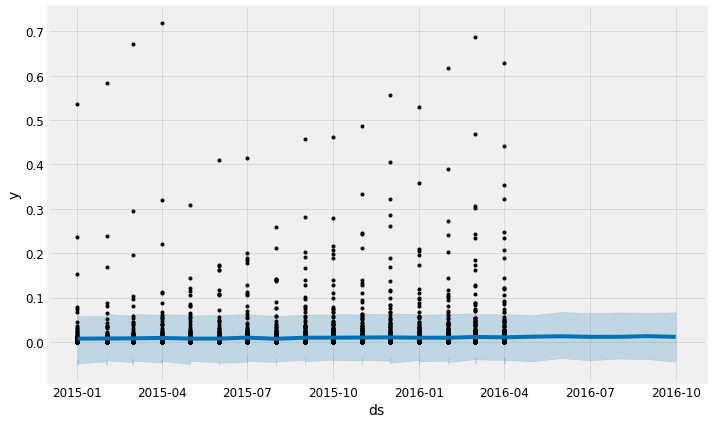

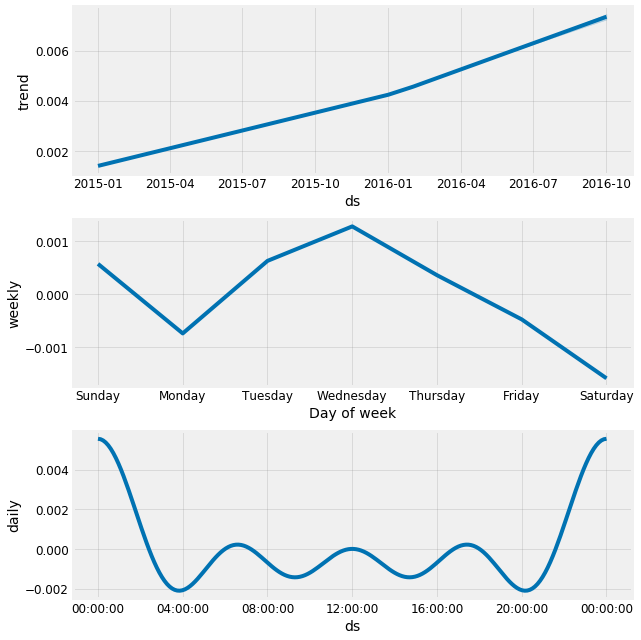

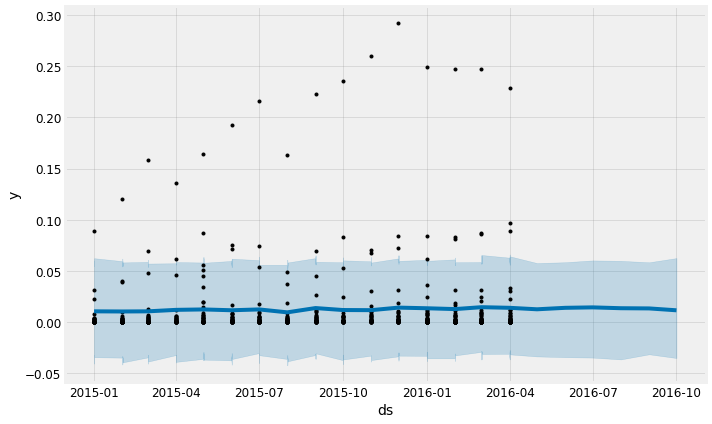

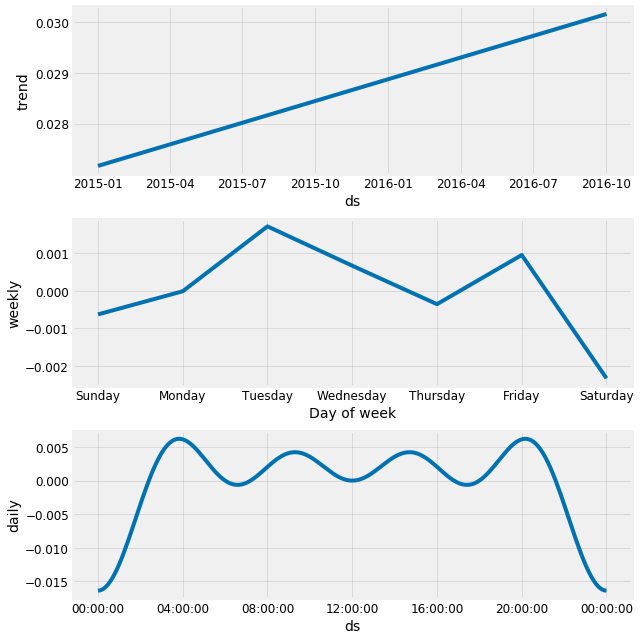

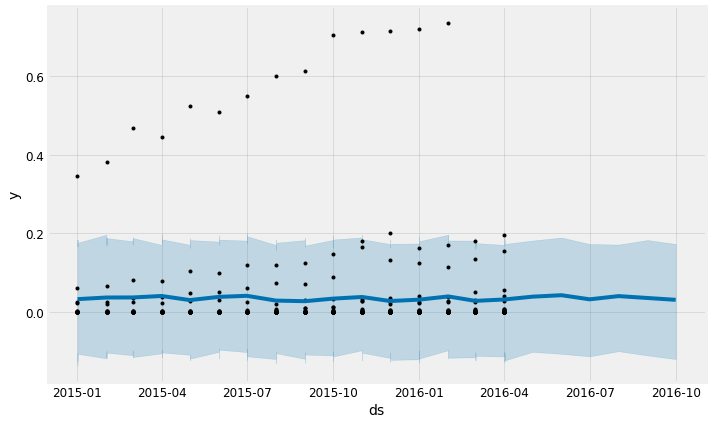

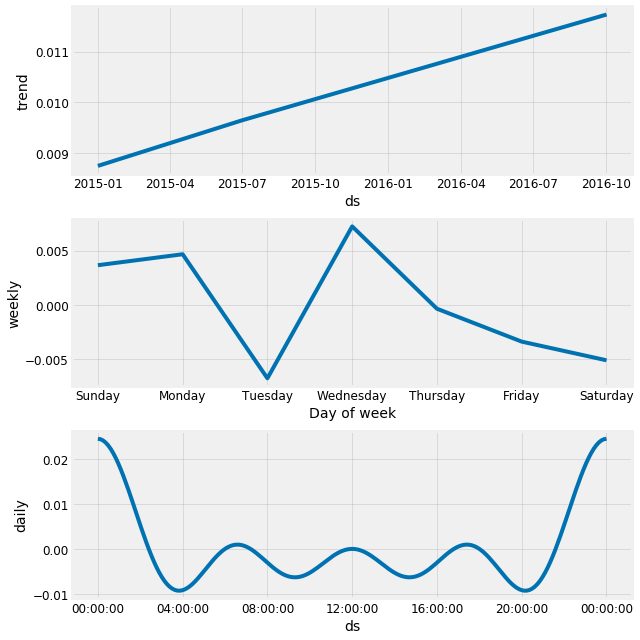

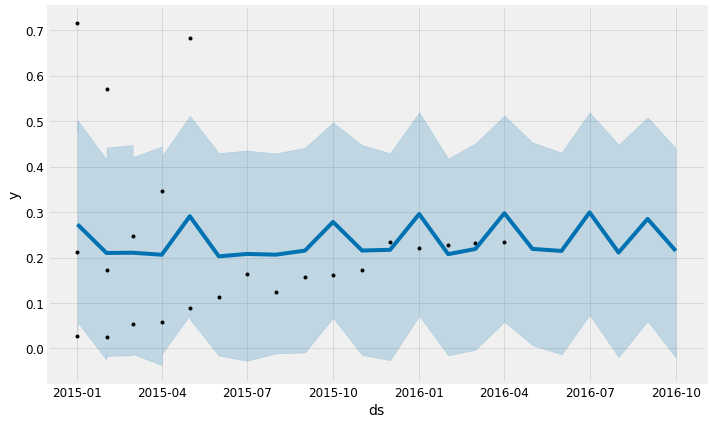

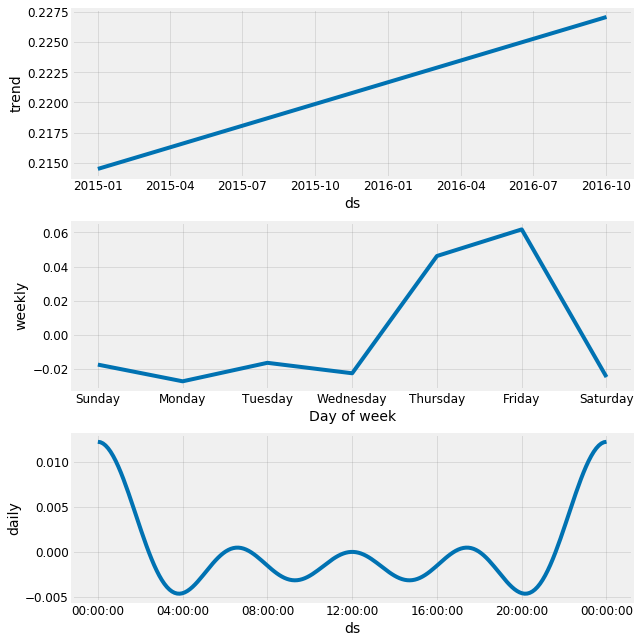

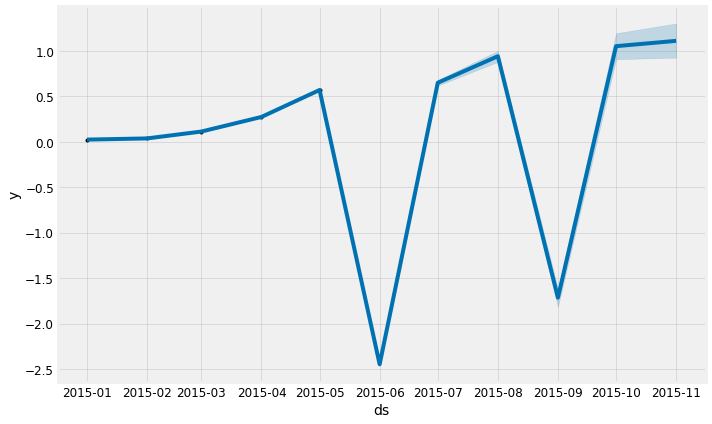

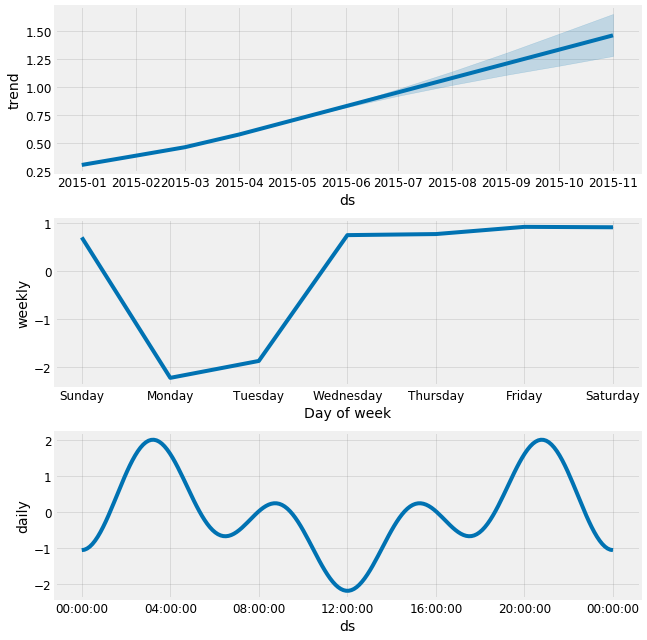

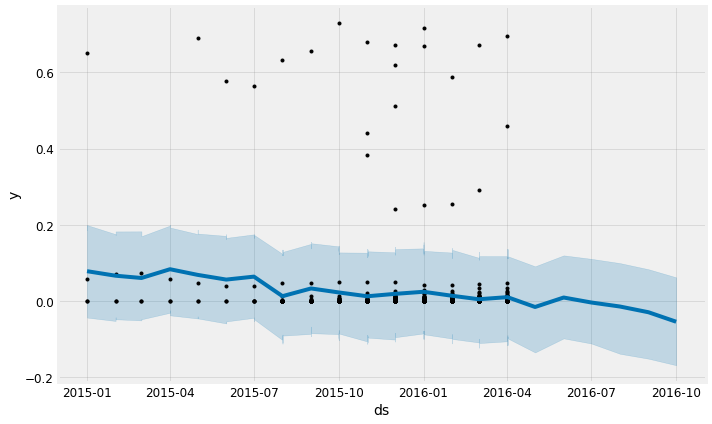

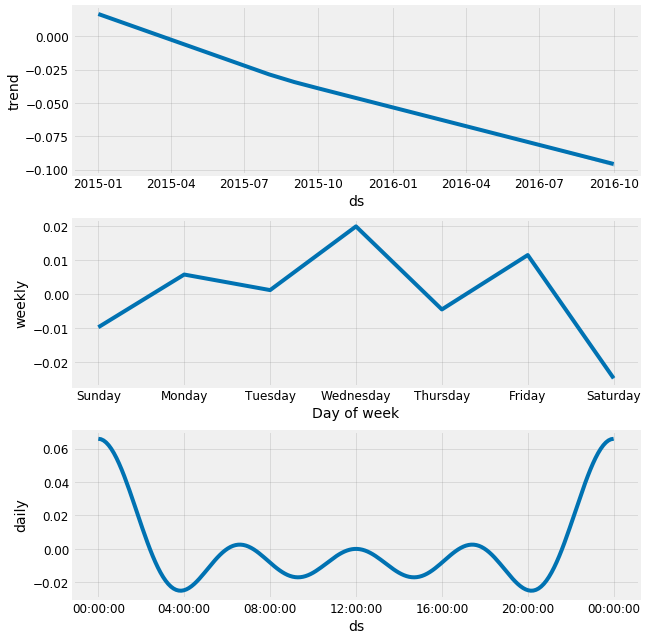

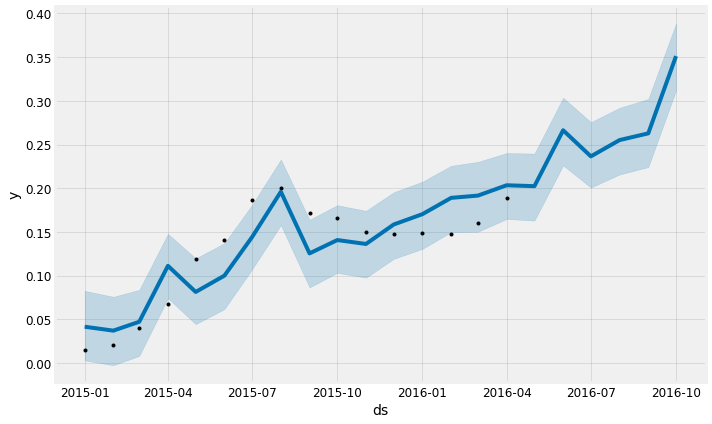

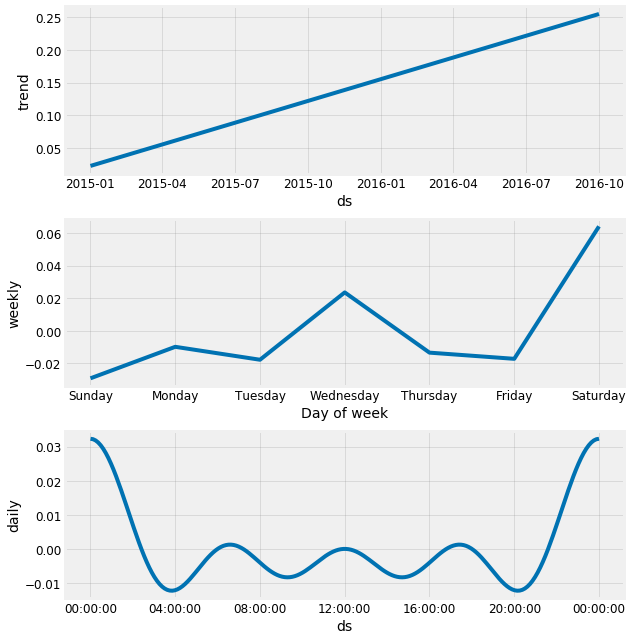

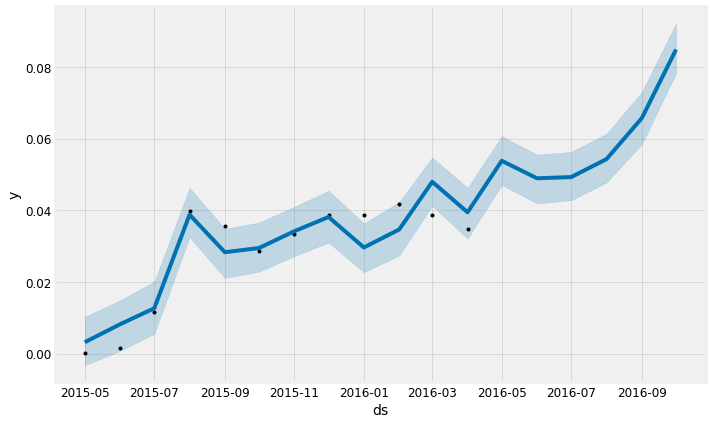

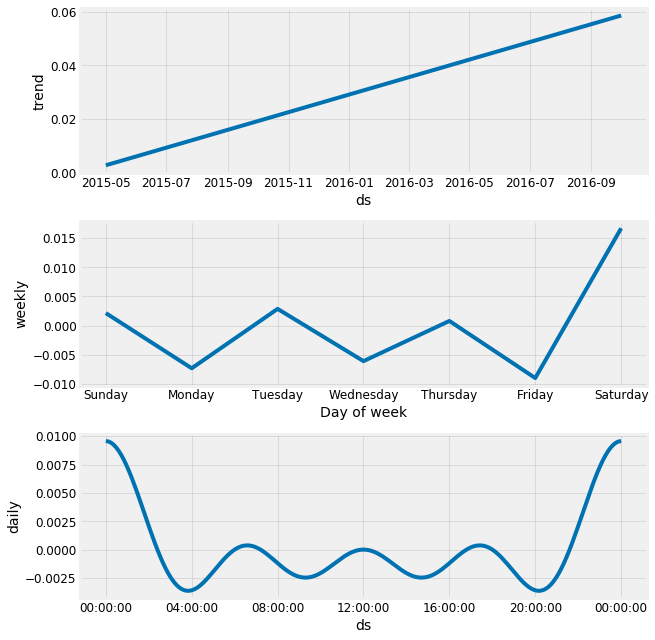

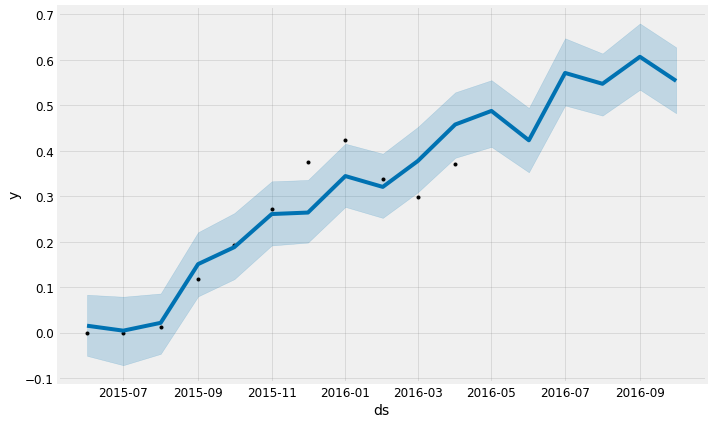

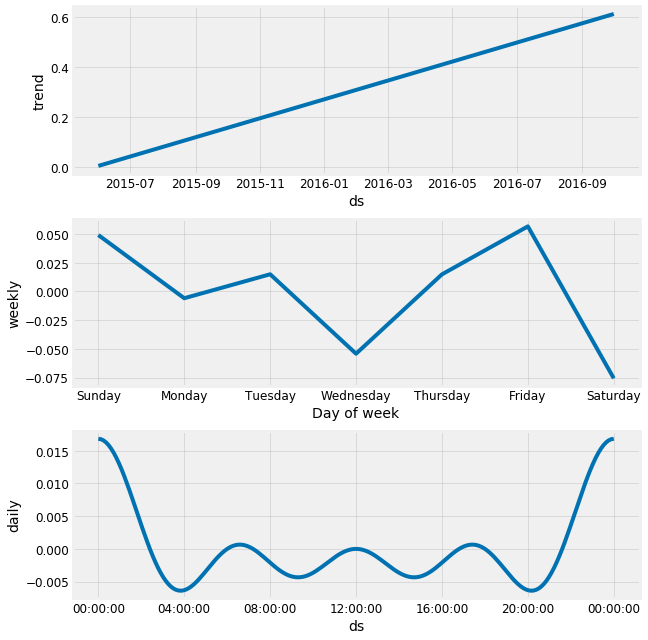

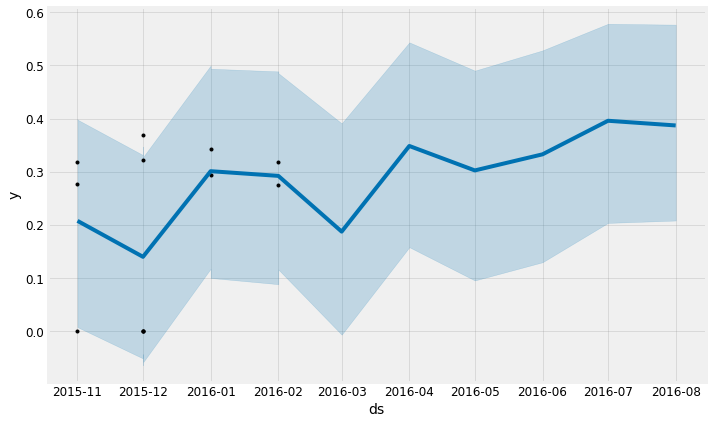

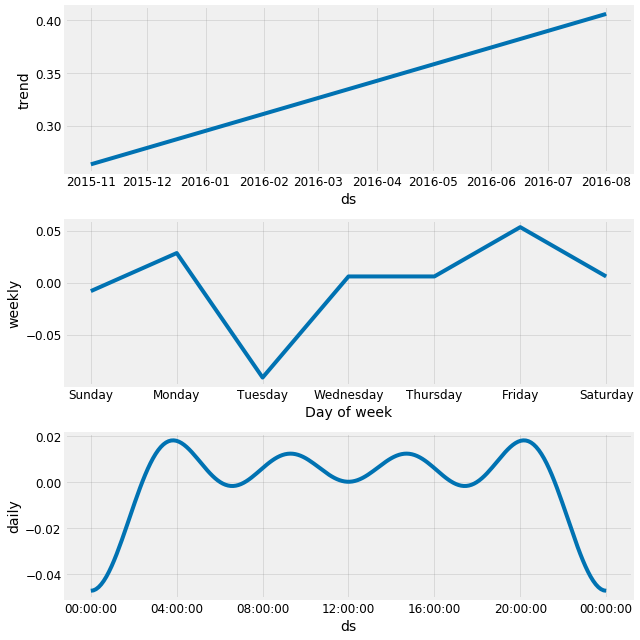

In [152]:
vendor_prediction_graphs(EATSFin4)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series.

Some intial comments about the graphs:

Given first graph of y vs ds, can suspect that most graphs have a positive regression despite how sharp or not sharp upward slope is.

However, when looking more closely at the breakdown of each graph, different trends are revealed.
Most Vendors' yearly trends have an upward trend except for one Vendor: Vendor F.
Most Vendors' weekly trends' peak on Wednesday's and Friday's.
Most Vendors' daily trends' peak during the first four and last four hours of a 24-hr time range. Consideration needed of when this 24-hr time range starts and stops in a day. Then can determine which hours are the best time to push sales.

It would be a good idea to do away with Vendor F since there is no ROI.
Due to Sunday, Monday, Tuesday, Thursday and somewhat Saturday not being high days, need to reconsider marketing strategies in order to increase sales on those low-performing days.

# Validity of Model/Model Performance:

In [153]:
from fbprophet.diagnostics import cross_validation, performance_metrics

def vendor_model_performance(df):
    prediction = {}
    df = df.rename(columns={'Date': 'ds','% Gross Bookings': 'y', 'Vendor Name': 'vendor'})
    list_vendors = df.vendor.unique()

    for vendor in list_vendors:
        vendor_df = df.loc[df['vendor'] == vendor]
        # the Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
        my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0)
        my_model.fit(vendor_df)
        future_dates = my_model.make_future_dataframe(periods=6, freq='MS')
        forecast = my_model.predict(future_dates)
        prediction[vendor] = forecast #dictionary data type
        
        #Performance Metrics of each forecast model
        df_cv = cross_validation(my_model, initial = '50 days', horizon= '30 days')
        df_pm = performance_metrics(df_cv)
        
    return df_pm

In [154]:
vendor_model_performance(EATSFin4)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.diagnostics:Making 26 forecasts with cutoffs between 2015-02-21 00:00:00 and 2016-03-02 00:00:00
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.diagnostics:Making 26 forecasts with cutoffs between 2015-02-21 00:00:00 and 2016-03-02 00:00:00
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.diagnostics:Making 26 forecasts with cutoffs between 2015-02-21 00:00:00 and 2016-03-02 00:00:00
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 17.0.
INFO:fbprophet.diagnostics

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 2.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 2.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 4.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 4.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 5.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 5.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.
INFO:fbprophet.forecaster:n_chan

,horizon,mse,rmse,mae,mape,coverage
0,30 days,0.000144,0.011992,0.011992,0.037690,1.0
1,30 days,0.001009,0.031770,0.031770,0.115771,1.0


Right here, the RMSE values were between 0.01 and .03 which were better values for what we had for simple Linear Regression model (0.6) that used data not split up into different Vendor groups to train its model. Improved model performance using FB's Prophet could be explained by Linear Regression model being trained on a bigger/more complex dataset (more variability) that would decrease model's accuracy. Though the comparison was not equal between Linear Regression model and FB's Prophet model, FB's Prophet's RMSE values alone were a good indicator that built models were good predictors of future '% Gross Bookings' spent in May 2016.

Why I chose Prophet for forecasting is it is super fast, an additive model (predictor derived from data) where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. Also, it works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. Given all that Prophet detects, I went ahead and tried this.

The descent in Vendor F's graphs would not have been detected if it were not for how I broke down the data that was fed into Prophet predictor. This downward trend was not as clear in the initial matplotlib rendering of true '% Gross Bookings' data prior to predictions. It goes to show that Facebook's Prophet is a good tool to use to detect granular fluctuations in datasets that a human eye cannot pick up from inspecting a graph.

Alternatives I considered were Autoregression and Linear Regression, but these were too simple. These models are usually reserved for data that is linear without much complexity. Initially, these models seemed promising given how basic the data looked. However, after closer consideration, data set had to be broken down into 10 different Vendors, which allowed a closer look at how '% Gross Bookings' trended from month to month.

Data analysis concerns: Not comparing how much Fees there were incurred per Vendor in order to see if Gross Amount was significantly higher than Fees in order to carry on with investment in a particular Vendor. If it was the other way around (high Fees compared to Gross Amount) then strong consideration to not carry on with that Vendor would be advised. I would have liked to do this in order to resolve any financial imbalances.   

Other concerns I have regarding the model I picked is that Additive models tend to overfit and have multicollinaerity. These are bad because overfitting causes the model to lack generalization, which would lead to a huge gap in performance level between Training dataset and Test dataset. With overfitting, the Training dataset would perform really well with the model, whereas, the Test set would perform really poorly. An ideal model would have performance metric values very close between Training and Test Sets. Multicollinearity is bad because it would produce redundant predictors. Coefficient estimates (which are tied to predictors) of multiple regression can change eratically in response to small changes to the model or the data.

In the end, despite some concerns I had, after analyzing the dataset for EATS finance, I would move forward with Vendor A and Products 4 and 9 to maintain high sales and drop Vendor F due to being a negative ROI in the long run.